# Spark SQL and Datasets

In Chapters 4 and 5, we covered Spark SQL and the DataFrame API. We looked at
how to connect to built-in and external data sources, took a peek at the Spark SQL
engine, and explored topics such as the interoperability between SQL and DataFrames, creating and managing views and tables, and advanced DataFrame and SQL transformations.
Although we briefly introduced the Dataset API in Chapter 3, we skimmed over the
salient aspects of how Datasets—strongly typed distributed collections—are created,
stored, and serialized and deserialized in Spark.
In this chapter, we go under the hood to understand Datasets: we’ll explore working
with Datasets in Java and Scala, how Spark manages memory to accommodate Dataset constructs as part of the high-level API, and the costs associated with using Datasets.
## Single API for Java and Scala
As you may recall from Chapter 3 (Figure 3-1 and Table 3-6), Datasets offer a unified
and singular API for strongly typed objects. Among the languages supported by Spark, only Scala and Java are strongly typed; hence, Python and R support only the untyped DataFrame API.

Datasets are domain-specific typed objects that can be operated on in parallel using
functional programming or the DSL operators you’re familiar with from the DataFrame API.

Thanks to this singular API, Java developers no longer risk lagging behind. For example, any future interface or behavior changes to Scala’s groupBy(), flatMap(), map(),or filter() API will be the same for Java too, because it’s a singular interface that is
common to both implementations.
## Scala Case Classes and JavaBeans for Datasets
If you recall from Chapter 3 (Table 3-2), Spark has internal data types, such as String
Type, BinaryType, IntegerType, BooleanType, and MapType, that it uses to map seamlessly to the language-specific data types in Scala and Java during Spark operations. This mapping is done via encoders, which we discuss later in this chapter.

In order to create Dataset[T], where T is your typed object in Scala, you need a case
class that defines the object. Using our example data from Chapter 3 (Table 3-1), say
we have a JSON file with millions of entries about bloggers writing about Apache Spark in the following format:
~~~
{id: 1, first: "Jules", last: "Damji", url: "https://tinyurl.1", date:
"1/4/2016", hits: 4535, campaigns: {"twitter", "LinkedIn"}},
...
{id: 87, first: "Brooke", last: "Wenig", url: "https://tinyurl.2", date:
"5/5/2018", hits: 8908, campaigns: {"twitter", "LinkedIn"}}
~~~
To create a distributed Dataset[Bloggers], we must first define a Scala case class that
defines each individual field that comprises a Scala object. This case class serves as a
blueprint or schema for the typed object Bloggers:
~~~
// In Scala
case class Bloggers(id:Int, first:String, last:String, url:String, date:String,
hits: Int, campaigns:Array[String])
~~~
We can now read the file from the data source:
~~~
val bloggers = "../data/bloggers.json"
val bloggersDS = spark
 .read
 .format("json")
 .option("path", bloggers)
 .load()
 .as[Bloggers]
 ~~~~
Each row in the resulting distributed data collection is of type Bloggers.
Similarly, you can create a JavaBean class of type Bloggers in Java and then use
encoders to create a Dataset\<Bloggers>:
~~~
// In Java
import org.apache.spark.sql.Encoders;
import java.io.Serializable;
public class Bloggers implements Serializable {
 private int id;
 private String first;
 private String last;
 private String url;
 private String date;
 private int hits;
 private Array[String] campaigns;
// JavaBean getters and setters
int getID() { return id; }
void setID(int i) { id = i; }
String getFirst() { return first; }
void setFirst(String f) { first = f; }
String getLast() { return last; }
void setLast(String l) { last = l; }
String getURL() { return url; }
void setURL (String u) { url = u; }
String getDate() { return date; }
Void setDate(String d) { date = d; }
int getHits() { return hits; }
void setHits(int h) { hits = h; }
Array[String] getCampaigns() { return campaigns; }
void setCampaigns(Array[String] c) { campaigns = c; }
}
// Create Encoder
Encoder<Bloggers> BloggerEncoder = Encoders.bean(Bloggers.class);
String bloggers = "../bloggers.json"
Dataset<Bloggers>bloggersDS = spark
 .read
 .format("json")
 .option("path", bloggers)
 .load()
 .as(BloggerEncoder);
~~~
As you can see, creating Datasets in Scala and Java requires a bit of forethought, as
you have to know all the individual column names and types for the rows you are
reading. Unlike with DataFrames, where you can optionally let Spark infer the
schema, the Dataset API requires that you define your data types ahead of time and
that your case class or JavaBean class matches your schema.

The names of the fields in the Scala case class or Java class definition must match the order in the data source. The column names for each row in the data are automatically mapped to the corresponding names in the class and the types are automatically
preserved.

You may use an existing Scala case class or JavaBean class if the field names match
with your input data. Working with the Dataset API is as easy, concise, and
declarative as working with DataFrames. For most of the Dataset’s transformations,you can use the same relational operators you’ve learned about in the previous chapters.
Let’s examine some aspects of working with a sample Dataset.

## Working with Datasets
One simple and dynamic way to create a sample Dataset is using a SparkSession
instance. In this scenario, for illustration purposes, we dynamically create a Scala
object with three fields: uid (unique ID for a user), uname (randomly generated user‐
name string), and usage (minutes of server or service usage).
### Creating Sample Data
First, let’s generate some sample data:
~~~
// In Scala
import scala.util.Random._
// Our case class for the Dataset
case class Usage(uid:Int, uname:String, usage: Int)
val r = new scala.util.Random(42)
// Create 1000 instances of scala Usage class
// This generates data on the fly
val data = for (i <- 0 to 1000)
 yield (Usage(i, "user-" + r.alphanumeric.take(5).mkString(""),
 r.nextInt(1000)))
// Create a Dataset of Usage typed data
val dsUsage = spark.createDataset(data)
dsUsage.show(10)
~~~
In Java the idea is similar, but we have to use explicit Encoders (in Scala, Spark handles this implicitly):
~~~
// In Java
import org.apache.spark.sql.Encoders;
import org.apache.commons.lang3.RandomStringUtils;
import java.io.Serializable;
import java.util.Random;
import java.util.ArrayList;
import java.util.List;
// Create a Java class as a Bean
public class Usage implements Serializable {
 int uid; // user id
 String uname; // username
 int usage; // usage
 public Usage(int uid, String uname, int usage) {
 this.uid = uid;
 this.uname = uname;
 this.usage = usage;
 }
 // JavaBean getters and setters
 public int getUid() { return this.uid; }
 public void setUid(int uid) { this.uid = uid; }
 public String getUname() { return this.uname; }
 public void setUname(String uname) { this.uname = uname; }
 public int getUsage() { return this.usage; }
 public void setUsage(int usage) { this.usage = usage; }
 public Usage() {
 }
 public String toString() {
 return "uid: '" + this.uid + "', uame: '" + this.uname + "',
 usage: '" + this.usage + "'";
 }
}
// Create an explicit Encoder
Encoder<Usage> usageEncoder = Encoders.bean(Usage.class);
Random rand = new Random();
rand.setSeed(42);
List<Usage> data = new ArrayList<Usage>()
// Create 1000 instances of Java Usage class
for (int i = 0; i < 1000; i++) {
 data.add(new Usage(i, "user" +
 RandomStringUtils.randomAlphanumeric(5),
 rand.nextInt(1000));

// Create a Dataset of Usage typed data
Dataset<Usage> dsUsage = spark.createDataset(data, usageEncoder);
~~~
The generated Dataset between Scala and Java will differ because the random seed algorithm may be different. Hence, your Scala’s and Java’s query results will differ.

Now that we have our generated Dataset, dsUsage, let’s perform some of the common
transformations we have done in previous chapters.

## Transforming Sample Data
Recall that Datasets are strongly typed collections of domain-specific objects. These
objects can be transformed in parallel using functional or relational operations.
Examples of these transformations include map(), reduce(), filter(), select(),
and aggregate(). As examples of higher-order functions, these methods can take
lambdas, closures, or functions as arguments and return the results. As such, they
lend themselves well to functional programming.

Scala is a functional programming language, and more recently lambdas, functional
arguments, and closures have been added to Java too. Let’s try a couple of higherorder functions in Spark and use functional programming constructs with the sample
data we created earlier.

#### Higher-order functions and functional programming
For a simple example, let’s use filter() to return all the users in our dsUsage Dataset
whose usage exceeds 900 minutes. One way to do this is to use a functional expres‐
sion as an argument to the filter() method:
~~~
// In Scala
import org.apache.spark.sql.functions._
dsUsage
 .filter(d => d.usage > 900)
 .orderBy(desc("usage"))
 .show(5, false)
Another way is to define a function and supply that function as an argument to
filter():
def filterWithUsage(u: Usage) = u.usage > 900
dsUsage.filter(filterWithUsage(_)).orderBy(desc("usage")).show(5)
~~~
In the first case we used a lambda expression, {d.usage > 900}, as an argument to
the filter() method, whereas in the second case we defined a Scala function, def
filterWithUsage(u: Usage) = u.usage > 900. In both cases, the filter() method
iterates over each row of the Usage object in the distributed Dataset and applies the
expression or executes the function, returning a new Dataset of type Usage for rows
where the value of the expression or function is true. (See the Scala documentation
for method signature details.)

In Java, the argument to filter() is of type FilterFunction\<T>. This can be defined
either inline anonymously or with a named function. For this example, we will define
our function by name and assign it to the variable f. Applying this function in
filter() will return a new Dataset with all the rows for which our filter condition is
true:
~~~
// In Java
// Define a Java filter function
FilterFunction<Usage> f = new FilterFunction<Usage>() {
 public boolean call(Usage u) {
 return (u.usage > 900);
 }
};
// Use filter with our function and order the results in descending order
dsUsage.filter(f).orderBy(col("usage").desc()).show(5);
+---+----------+-----+
|uid|uname |usage|
+---+----------+-----+
|67 |user-qCGvZ|997 |
|878|user-J2HUU|994 |
|668|user-pz2Lk|992 |
|750|user-0zWqR|991 |
|242|user-g0kF6|989 |
+---+----------+-----+
only showing top 5 rows
~~~
Not all lambdas or functional arguments must evaluate to Boolean values; they can
return computed values too. Consider this example using the higher-order function
map(), where our aim is to find out the usage cost for each user whose usage value is
over a certain threshold so we can offer those users a special price per minute.
~~~
// In Scala
// Use an if-then-else lambda expression and compute a value
dsUsage.map(u => {if (u.usage > 750) u.usage * .15 else u.usage * .50 })
 .show(5, false)
// Define a function to compute the usage
def computeCostUsage(usage: Int): Double = {
 if (usage > 750) usage * 0.15 else usage * 0.50
}
// Use the function as an argument to map()
dsUsage.map(u => {computeCostUsage(u.usage)}).show(5, false)
+------+
|value |
+------+
|262.5 |
|251.0 |
|85.0 |
|136.95|
|123.0 |
+------+
only showing top 5 rows
~~~
To use map() in Java, you have to define a MapFunction\<T>. This can either be an
anonymous class or a defined class that extends MapFunction\<T>. For this example,
we use it inline—that is, in the method call itself:
~~~
// In Java
// Define an inline MapFunction
dsUsage.map((MapFunction\<Usage, Double>) u -> {
 if (u.usage > 750)
 return u.usage * 0.15;
 else
 return u.usage * 0.50;
}, Encoders.DOUBLE()).show(5); // We need to explicitly specify the Encoder
+------+
|value |
+------+
|65.0 |
|114.45|
|124.0 |
|132.6 |
|145.5 |
+------+
only showing top 5 rows
~~~
Though we have computed values for the cost of usage, we don’t know which users
the computed values are associated with. How do we get this information?

The steps are simple:
1. Create a Scala case class or JavaBean class, UsageCost, with an additional field or
column named cost.
2. Define a function to compute the cost and use it in the map() method.

Here’s what this looks like in Scala:
~~~
// In Scala
// Create a new case class with an additional field, cost
case class UsageCost(uid: Int, uname:String, usage: Int, cost: Double)
// Compute the usage cost with Usage as a parameter
// Return a new object, UsageCost
def computeUserCostUsage(u: Usage): UsageCost = {
 val v = if (u.usage > 750) u.usage * 0.15 else u.usage * 0.50
 UsageCost(u.uid, u.uname, u.usage, v)
}
// Use map() on our original Dataset
dsUsage.map(u => {computeUserCostUsage(u)}).show(5)
+---+----------+-----+------+
|uid| uname|usage| cost|
+---+----------+-----+------+
| 0|user-Gpi2C| 525| 262.5|
| 1|user-DgXDi| 502| 251.0|
| 2|user-M66yO| 170| 85.0|
| 3|user-xTOn6| 913|136.95|
| 4|user-3xGSz| 246| 123.0|
+---+----------+-----+------+
only showing top 5 rows
~~~
Now we have a transformed Dataset with a new column, cost, computed by the func‐
tion in our map() transformation, along with all the other columns.
Likewise, in Java, if we want the cost associated with each user we need to define a
JavaBean class UsageCost and MapFunction\<T>. For the complete JavaBean example,
see the book’s GitHub repo; for brevity, we will only show the inline MapFunction\<T>
here:
~~~
// In Java
// Get the Encoder for the JavaBean class
Encoder<UsageCost> usageCostEncoder = Encoders.bean(UsageCost.class);
// Apply map() function to our data
dsUsage.map( (MapFunction<Usage, UsageCost>) u -> {
 double v = 0.0;
 if (u.usage > 750) v = u.usage * 0.15; else v = u.usage * 0.50;
 return new UsageCost(u.uid, u.uname,u.usage, v); },
 usageCostEncoder).show(5);
+------+---+----------+-----+
| cost|uid| uname|usage|
+------+---+----------+-----+
| 65.0| 0|user-xSyzf| 130|
|114.45| 1|user-iOI72| 763|
| 124.0| 2|user-QHRUk| 248|
| 132.6| 3|user-8GTjo| 884|
| 145.5| 4|user-U4cU1| 970|
+------+---+----------+-----+
only showing top 5 rows
~~~
There are a few things to observe about using higher-order functions and Datasets:
* We are using typed JVM objects as arguments to functions.
* We are using dot notation (from object-oriented programming) to access individual fields within the typed JVM object, making it easier to read.
* Some of our functions and lambda signatures can be type-safe, ensuring compiletime error detection and instructing Spark what data types to work on, what operations to perform, etc.
* Our code is readable, expressive, and concise, using Java or Scala language features in lambda expressions.
* Spark provides the equivalent of map() and filter() without higher-order functional constructs in both Java and Scala, so you are not forced to use functional programming with Datasets or DataFrames. Instead, you can simply use conditional DSL operators or SQL expressions: for example, dsUsage.filter("usage > 900") or dsUsage($"usage" > 900). (For more on this, see “Costs of Using Datasets” on page 170.)
* For Datasets we use encoders, a mechanism to efficiently convert data between JVM and Spark’s internal binary format for its data types (more on that in “Dataset Encoders” on page 168).

Higher-order functions and functional programming are not unique to Spark Datasets; you can use them with DataFrames too. Recall that a DataFrame is a Dataset[Row], where Row is a generic untyped JVM object that can hold different types of fields. The method signature takes expressions or functions that operate on Row, meaning that each Row’s data type can be input value to the expression or function.

#### Converting DataFrames to Datasets
For strong type checking of queries and constructs, you can convert DataFrames to
Datasets. To convert an existing DataFrame df to a Dataset of type SomeCaseClass,
simply use the df.as[SomeCaseClass] notation. We saw an example of this earlier:
~~~
// In Scala
val bloggersDS = spark
 .read
 .format("json")
 .option("path", "/data/bloggers/bloggers.json")
 .load()
 .as[Bloggers]
~~~
spark.read.format("json") returns a DataFrame<Row>, which in Scala is a type alias
for Dataset[Row]. Using .as[Bloggers] instructs Spark to use encoders, discussed
later in this chapter, to serialize/deserialize objects from Spark’s internal memory representation to JVM Bloggers objects.

## Memory Management for Datasets and DataFrames
Spark is an intensive in-memory distributed big data engine, so its efficient use of
memory is crucial to its execution speed. Throughout its release history, Spark’s
usage of memory has significantly evolved:
* Spark 1.0 used RDD-based Java objects for memory storage, serialization, and
deserialization, which was expensive in terms of resources and slow. Also, storage
was allocated on the Java heap, so you were at the mercy of the JVM’s garbage
collection (GC) for large data sets.
* Spark 1.x introduced Project Tungsten. One of its prominent features was a new
internal row-based format to lay out Datasets and DataFrames in off-heap mem‐
ory, using offsets and pointers. Spark uses an efficient mechanism called encoders
to serialize and deserialize between the JVM and its internal Tungsten format.
Allocating memory off-heap means that Spark is less encumbered by GC.
* Spark 2.x introduced the second-generation Tungsten engine, featuring wholestage code generation and vectorized column-based memory layout. Built on
ideas and techniques from modern compilers, this new version also capitalized
on modern CPU and cache architectures for fast parallel data access with the
“single instruction, multiple data” (SIMD) approach.

## Dataset Encoders
Encoders convert data in off-heap memory from Spark’s internal Tungsten format to
JVM Java objects. In other words, they serialize and deserialize Dataset objects from
Spark’s internal format to JVM objects, including primitive data types. For example,
an Encoder[T] will convert from Spark’s internal Tungsten format to Dataset[T].

Spark has built-in support for automatically generating encoders for primitive types
(e.g., string, integer, long), Scala case classes, and JavaBeans. Compared to Java and
Kryo serialization and deserialization, Spark encoders are significantly faster.
In our earlier Java example, we explicitly created an encoder:
~~~
Encoder<UsageCost> usageCostEncoder = Encoders.bean(UsageCost.class);
~~~    
However, for Scala, Spark automatically generates the bytecode for these efficient
converters. Let’s take a peek at Spark’s internal Tungsten row-based format.
Spark’s Internal Format Versus Java Object Format
Java objects have large overheads—header info, hashcode, Unicode info, etc. Even a
simple Java string such as “abcd” takes 48 bytes of storage, instead of the 4 bytes you
might expect. Imagine the overhead to create, for example, a MyClass(Int, String,
String) object.

Instead of creating JVM-based objects for Datasets or DataFrames, Spark allocates
off-heap Java memory to lay out their data and employs encoders to convert the data
from in-memory representation to JVM object. For example, Figure 6-1 shows how
the JVM object MyClass(Int, String, String) would be stored internally.
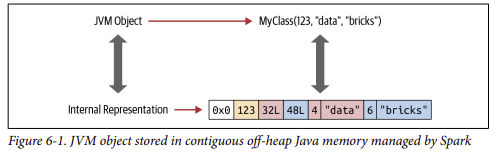
When data is stored in this contiguous manner and accessible through pointer arith‐
metic and offets, encoders can quickly serialize or deserialize that data. What does
that mean?

#### Serialization and Deserialization (SerDe)
A concept not new in distributed computing, where data frequently travels over the
network among computer nodes in a cluster, serialization and deserialization is the
process by which a typed object is encoded (serialized) into a binary presentation or
format by the sender and decoded (deserialized) from binary format into its respective data-typed object by the receiver.

For example, if the JVM object MyClass in Figure 6-1 had to be shared among nodes
in a Spark cluster, the sender would serialize it into an array of bytes, and the receiver would deserialize it back into a JVM object of type MyClass.

The JVM has its own built-in Java serializer and deserializer, but it’s inefficient
because (as we saw in the previous section) the Java objects created by the JVM in the
heap memory are bloated. Hence, the process is slow.

This is where the Dataset encoders come to the rescue, for a few reasons:
* Spark’s internal Tungsten binary format (see Figures 6-1 and 6-2) stores objects
off the Java heap memory, and it’s compact so those objects occupy less space.
* Encoders can quickly serialize by traversing across the memory using simple
pointer arithmetic with memory addresses and offsets (Figure 6-2).
* On the receiving end, encoders can quickly deserialize the binary representation
into Spark’s internal representation. Encoders are not hindered by the JVM’s
garbage collection pauses.
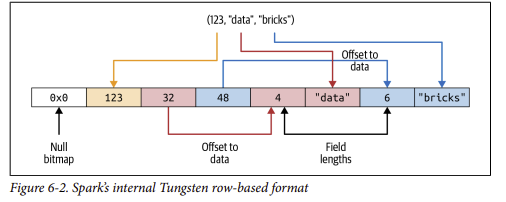
However, most good things in life come at a price, as we discuss next.

## Costs of Using Datasets
In “DataFrames Versus Datasets” on page 74 in Chapter 3, we outlined some of the
benefits of using Datasets—but these benefits come at a cost. As noted in the
preceding section, when Datasets are passed to higher-order functions such as fil
ter(), map(), or flatMap() that take lambdas and functional arguments, there is a
cost associated with deserializing from Spark’s internal Tungsten format into the JVM
object.

Compared to other serializers used before encoders were introduced in Spark, this
cost is minor and tolerable. However, over larger data sets and many queries, this cost
accrues and can affect performance.

#### Strategies to Mitigate Costs
One strategy to mitigate excessive serialization and deserialization is to use DSL expressions in your queries and avoid excessive use of lambdas as anonymous functions as arguments to higher-order functions. Because lambdas are anonymous and opaque to the Catalyst optimizer until runtime, when you use them it cannot efficiently discern what you’re doing (you’re not telling Spark what to do) and thus cannot optimize your queries (see “The Catalyst Optimizer” on page 77 in Chapter 3).

The second strategy is to chain your queries together in such a way that serialization
and deserialization is minimized. Chaining queries together is a common practice in
Spark.

Let’s illustrate with a simple example. Suppose we have a Dataset of type Person,
where Person is defined as a Scala case class:
~~~
// In Scala
Person(id: Integer, firstName: String, middleName: String, lastName: String,
gender: String, birthDate: String, ssn: String, salary: String)
~~~
We want to issue a set of queries to this Dataset, using functional programming.
Let’s examine a case where we compose a query inefficiently, in such a way that we
unwittingly incur the cost of repeated serialization and deserialization:

`import java.util.Calendar
val earliestYear = Calendar.getInstance.get(Calendar.YEAR) - 40
personDS
 // Everyone above 40: lambda-1
 .filter(x => x.birthDate.split("-")(0).toInt > earliestYear)

 // Everyone earning more than 80K
 .filter(dolar"salary" > 80000)
 // Last name starts with J: lambda-2
 .filter(x => x.lastName.startsWith("J"))

 // First name starts with D
 .filter(dolar"firstName".startsWith("D"))
 .count()`

As you can observe in Figure 6-3, each time we move from lambda to DSL (filter(dolar"salary" > 8000)) we incur the cost of serializing and deserializing the Person JVM object.
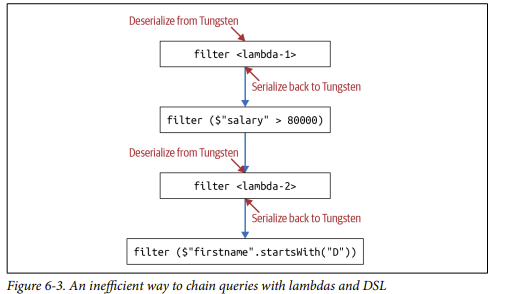
By contrast, the following query uses only DSL and no lambdas. As a result, it’s much
more efficient—no serialization/deserialization is required for the entire composed
and chained query:
~~~
personDS
 .filter(year(dolar"birthDate") > earliestYear) // Everyone above 40
 .filter(dolar"salary" > 80000) // Everyone earning more than 80K
 .filter(dolar"lastName".startsWith("J")) // Last name starts with J
 .filter(dolar"firstName".startsWith("D")) // First name starts with D
 .count()
 ~~~
For the curious, you can see the timing difference between the two runs in the notebook for this chapter in the book’s GitHub repo.

## Summary
In this chapter, we elaborated on how to work with Datasets in Java and Scala. We
explored how Spark manages memory to accommodate Dataset constructs as part of
its unified and high-level API, and we considered some of the costs associated with
using Datasets and how to mitigate those costs. We also showed you how to use Java
and Scala’s functional programming constructs in Spark.
Finally, we took a look under the hood at how encoders serialize and deserialize from
Spark’s internal Tungsten binary format to JVM objects.
In the next chapter, we’ll look at how to optimize Spark by examining efficient I/O
strategies, optimizing and tuning Spark configurations, and what attributes and signals to look for while debugging Spark applications.